**Описание проекта**

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами сети фитнес-центров перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.

**Описание данных**

Заказчик подготовил датасет, который содержит данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- Данные клиента за предыдущий до проверки факта оттока месяц:
 - `gender` — пол;
 - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
 - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - `Phone` — наличие контактного телефона;
 - `Age` — возраст;
 - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
 - `Group_visits` — факт посещения групповых занятий;
 - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
 - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Загрузка данных и изучение общей информации

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import roc_auc_score

In [3]:
df = pd.read_csv(r'C:\Users\564\Downloads\gym_churn.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
# Проверка на наличие явных дубликатов
df.duplicated().sum()

0

Пропусков и явных дубликатов не найдено

In [6]:
df['Contract_period'].unique()

array([ 6, 12,  1], dtype=int64)

В таблице присутствуют абонементы 3 типов

## Исследовательский анализ данных

### Посмотрим на датасет более детально

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


### Изучим средние значения в двух группах - тех, кто ушел в отток и тех, кто остался

In [8]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


**Вывод:**

Клиенты пришедшие по акции «приведи друга» и сотрудники компании-партнёра менее склонны к оттоку

### Построим гистограммы признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

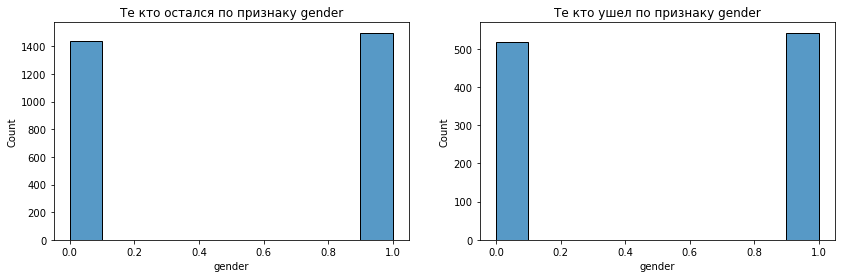

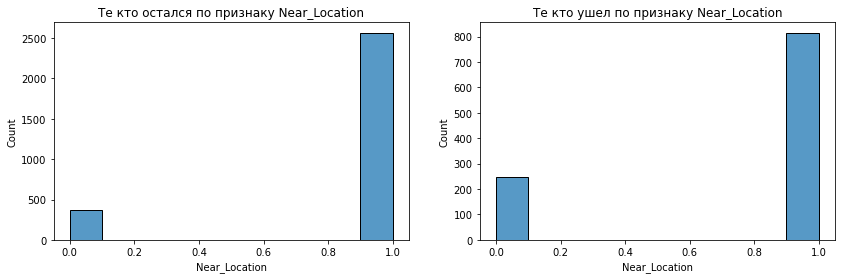

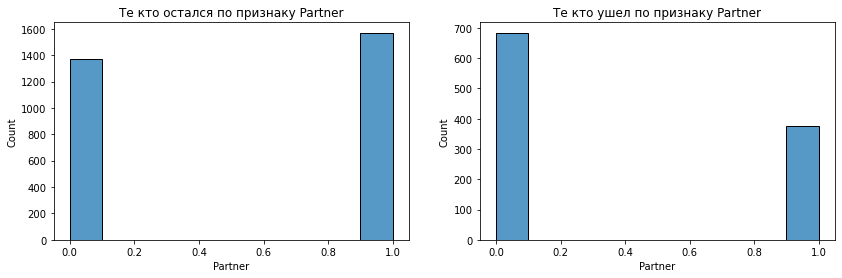

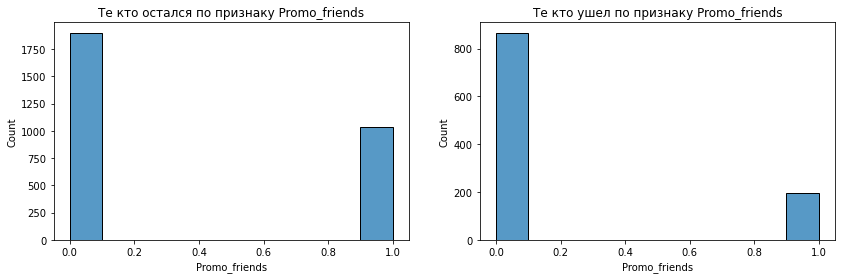

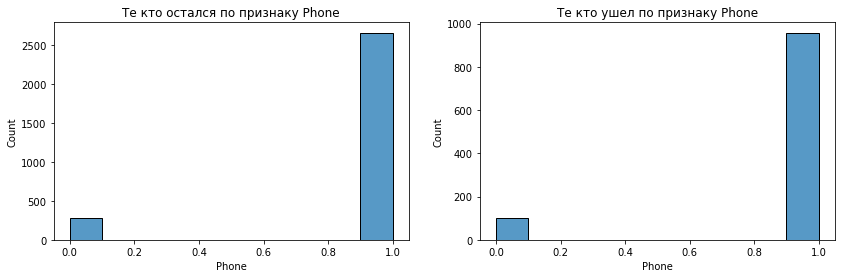

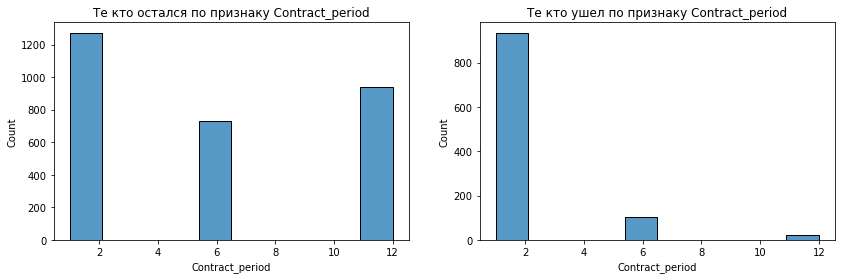

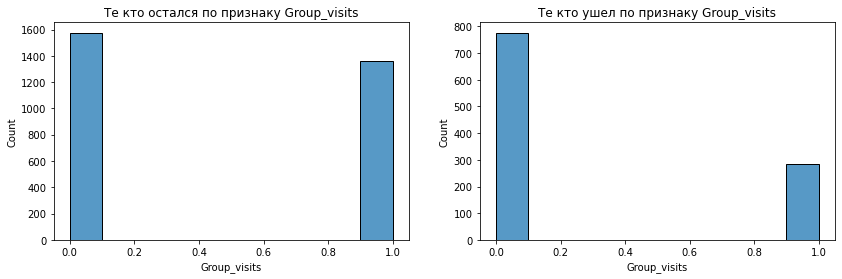

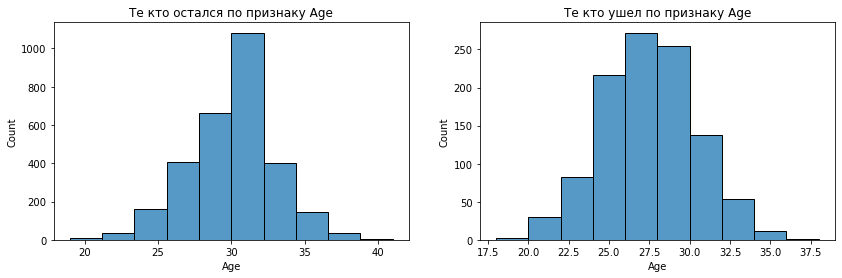

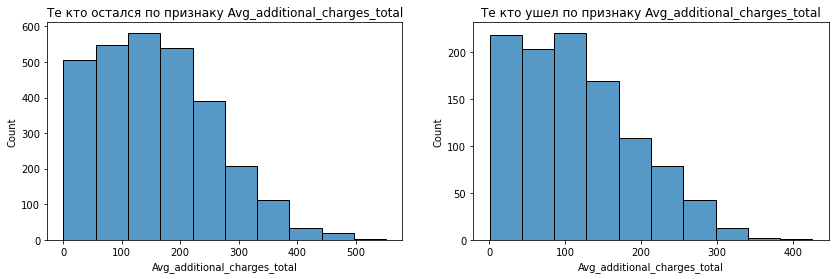

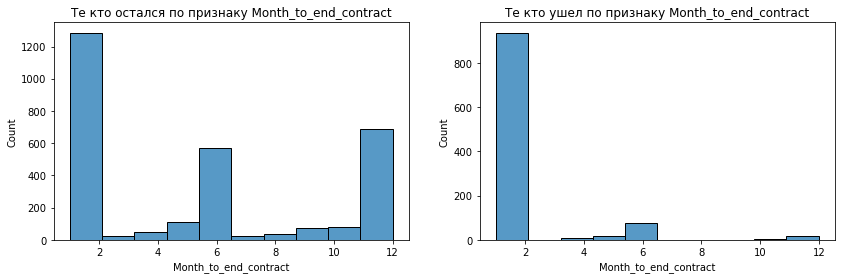

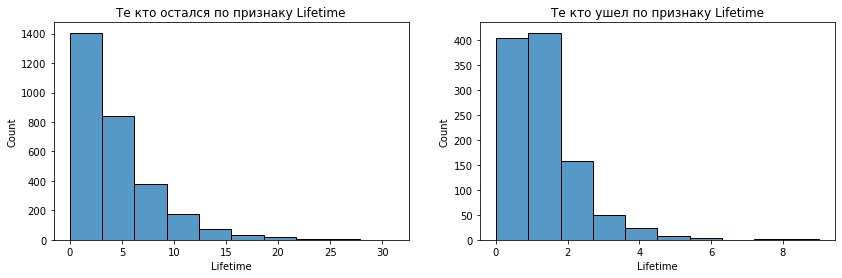

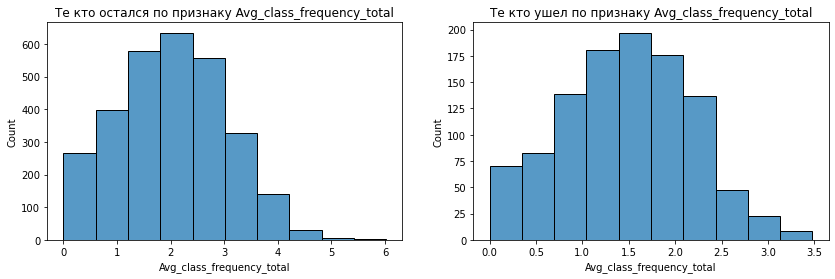

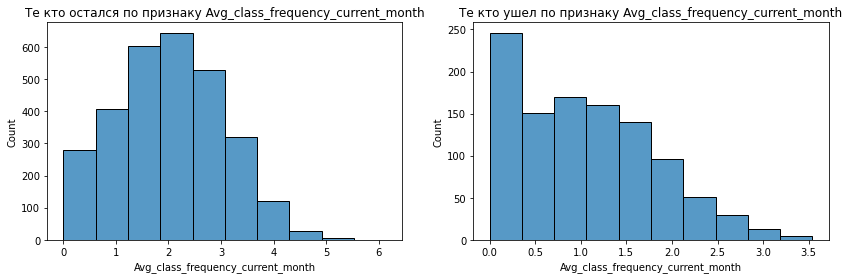

In [9]:
for feature in df.drop(columns=['Churn']):
    plt.subplots(figsize = (14, 4))
    sns.histplot(df.query('Churn == 0')[feature], bins=10, ax = plt.subplot(1, 2, 1))
    plt.title(f'Те кто остался по признаку {feature}')
    sns.histplot(df.query('Churn == 1')[feature], bins=10, ax = plt.subplot(1, 2, 2))
    plt.title(f'Те кто ушел по признаку {feature}')
    plt.show()

Распределения выглядят правдоподобно

### Построим матрицу корреляций

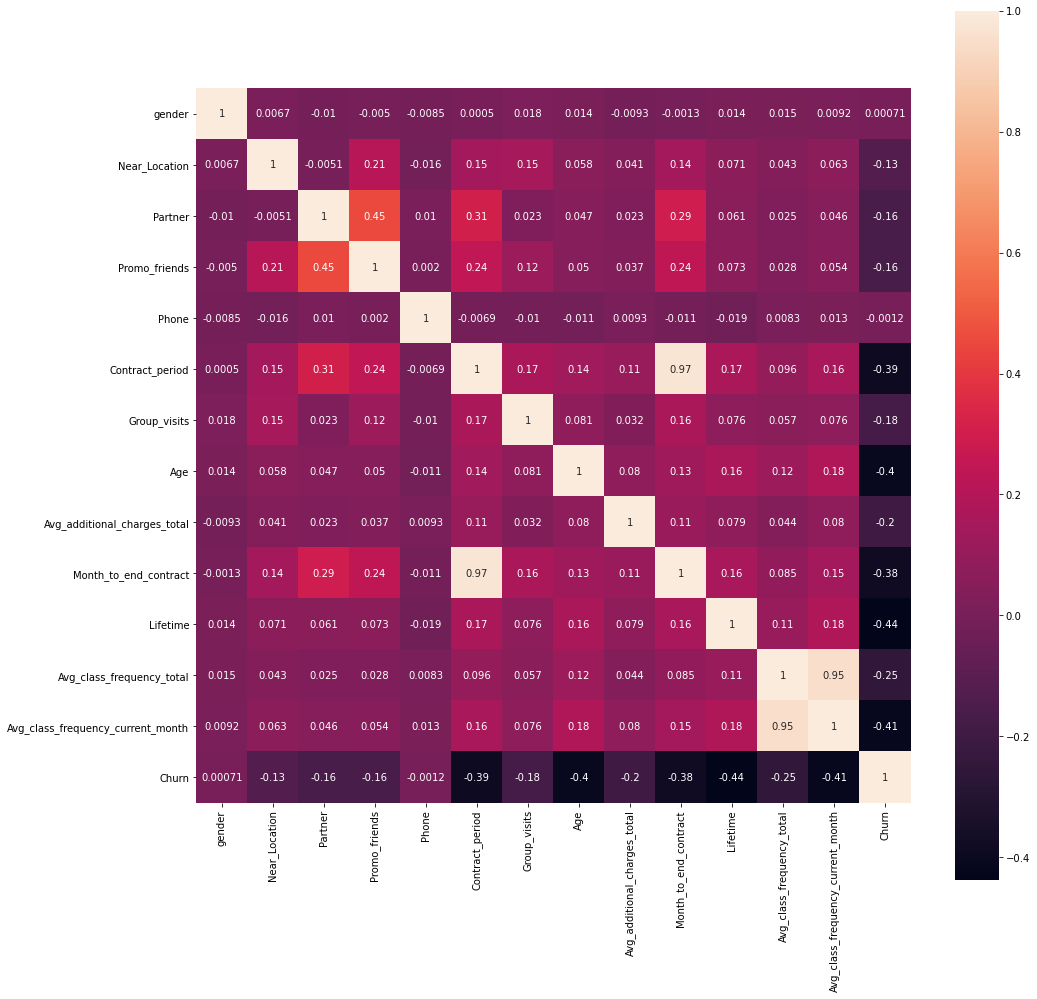

In [10]:
cm = df.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, square=True)
plt.show()

**Выводы:**
- Нулевая корреляция с целевой переменной у признаков gender и Phone
- Наиболее высокая корреляция с целевой переменной у признаков Avg_class_frequency_current_month, Lifetime и Age
- Слишком высокая корреляция между собой у признаков Avg_class_frequency_current_month и Avg_class_frequency_total, Month_to_end_contract и Contract_period

## Построим модель прогнозирования оттока клиентов

In [11]:
# Избавимся от сильно скоррелированных признаков
X = df.drop(columns=['Churn', 'Avg_class_frequency_total', 'Contract_period'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Стандартизируем данные

In [12]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [13]:
# функция, которая принимает на вход модель и данные и возвращает метрики

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    custom_predictions = [0 if i < threshold else 1 for i in probabilities]
    print('Метрики для прогноза с кастомным порогом')
    print(
    'Accuracy for custom: {:.2f}'.format(
        accuracy_score(y_test, custom_predictions)
        )
    )
    print(
    'Precision for custom: {:.2f}'.format(
        precision_score(y_test, custom_predictions)
        )
    )
    print(
    'Recall for custom: {:.2f}'.format(
        recall_score(y_test, custom_predictions)
        )
    )
    print('F1: {:.2f}'.format(f1_score(y_test, custom_predictions)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, custom_predictions)))

Определим threshold для функции make_prediction чтобы получить более точные метрики

In [14]:
df.query('Churn == 1')['Churn'].count() / df['Churn'].count()

0.26525

Применим модель логистической регрессии

In [15]:
threshold = 0.26525

make_prediction(LogisticRegression(solver='liblinear'), X_train_st, y_train,
X_test_st, y_test)

Метрики для прогноза с кастомным порогом
Accuracy for custom: 0.89
Precision for custom: 0.73
Recall for custom: 0.94
F1: 0.82
ROC_AUC: 0.91


Применим модель случайного леса

In [16]:
make_prediction(RandomForestClassifier(n_estimators = 100, random_state = 0),
X_train_st, y_train, X_test_st, y_test)

Метрики для прогноза с кастомным порогом
Accuracy for custom: 0.88
Precision for custom: 0.72
Recall for custom: 0.92
F1: 0.81
ROC_AUC: 0.89


**Вывод:**

На основании метрик, модель логистической регрессии показала себя лучше модели случайного леса.

## Проведем кластеризацию клиентов

### Стандартизируем данные

In [17]:
x_sc = scaler.fit_transform(X)

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

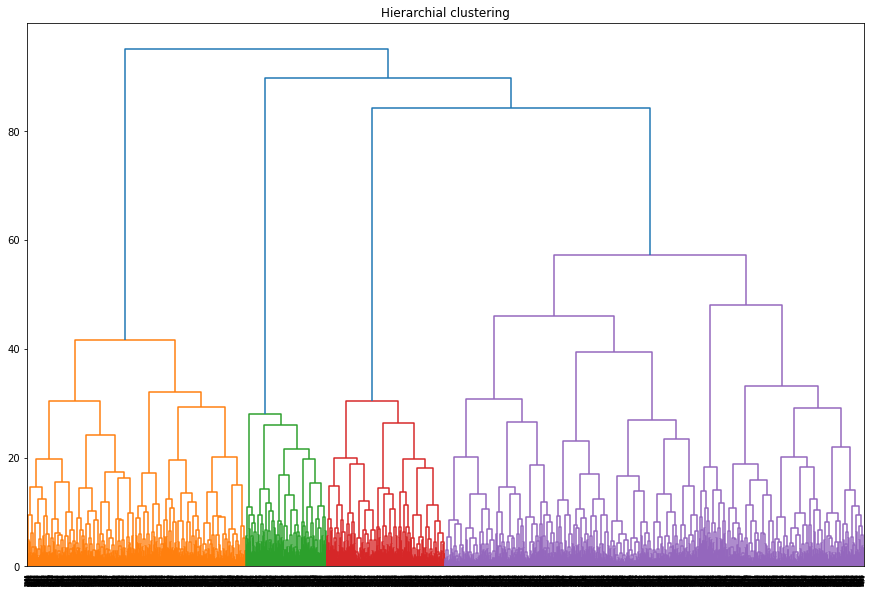

In [18]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

Предложенное оптимальное число кластеров 4, но визуально можно выделить до 6 кластеров

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [19]:
# За число кластеров примем n=5

km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
X['cluster'] = labels

### Посмотрим на средние значения признаков для кластеров

In [20]:
clusters = X.groupby('cluster').mean().round(2).reset_index(drop=True)
clusters['cluster'] = clusters.index
display(clusters)

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_current_month,cluster
0,0.49,0.99,0.95,1.00,0.91,0.53,29.63,154.09,6.73,4.29,1.92,0
1,0.50,1.00,0.38,0.05,0.90,0.00,30.34,174.39,4.70,5.17,2.24,1
2,0.51,1.00,0.23,0.11,0.90,0.18,26.81,111.07,1.72,1.42,0.98,2
3,0.50,0.00,0.49,0.07,0.91,0.23,28.70,137.38,2.83,3.03,1.60,3
4,0.55,1.00,0.27,0.08,0.90,1.00,30.25,155.21,4.71,4.48,2.04,4


In [21]:
clusters = X.groupby('cluster', as_index=False).mean().round(2)
display(clusters)

,cluster,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_current_month
0,0,0.49,0.99,0.95,1.00,0.91,0.53,29.63,154.09,6.73,4.29,1.92
1,1,0.50,1.00,0.38,0.05,0.90,0.00,30.34,174.39,4.70,5.17,2.24
2,2,0.51,1.00,0.23,0.11,0.90,0.18,26.81,111.07,1.72,1.42,0.98
3,3,0.50,0.00,0.49,0.07,0.91,0.23,28.70,137.38,2.83,3.03,1.60
4,4,0.55,1.00,0.27,0.08,0.90,1.00,30.25,155.21,4.71,4.48,2.04


### Построим распределения признаков для кластеров

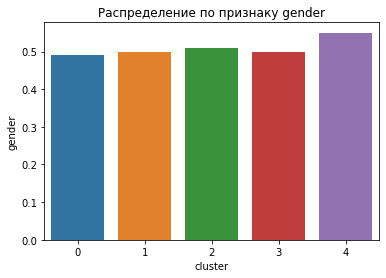

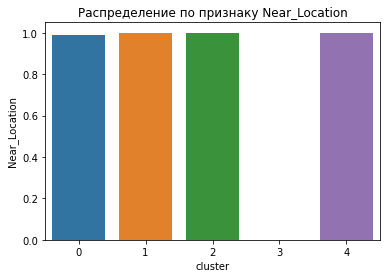

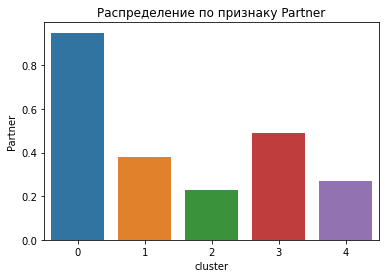

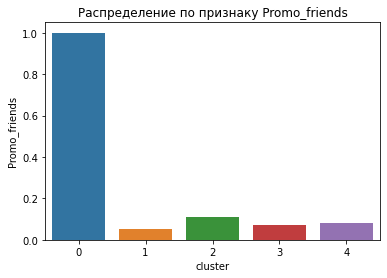

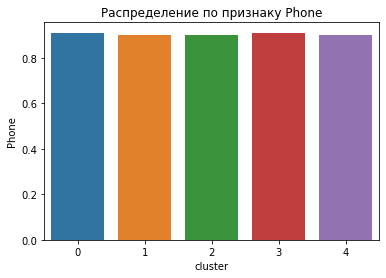

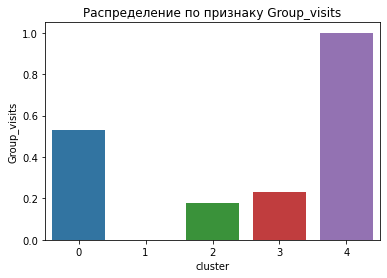

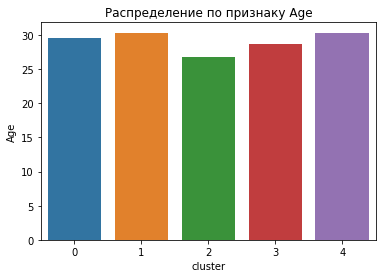

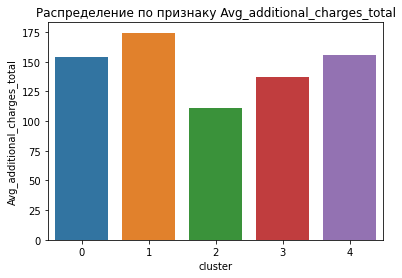

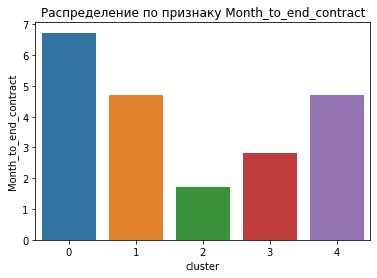

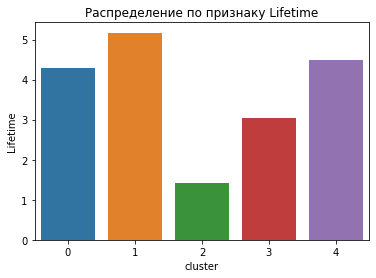

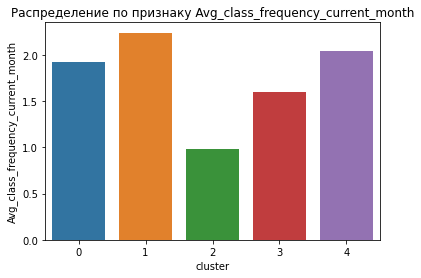

In [22]:
for c in clusters.drop(columns=['cluster']):
    sns.barplot(x='cluster', y=c, data=clusters)
    plt.title(f'Распределение по признаку {c}')
    plt.show()

**Вывод:**

Можно заметить существенные различия по всем признакам, за исключением пола, возраста и наличия контактного телефона

### Для каждого кластера посчитаем долю оттока

In [23]:
X['Churn'] = y
X.groupby('cluster')['Churn'].sum() / X.groupby('cluster')['Churn'].count()

cluster
0    0.108000
1    0.046481
2    0.741294
3    0.400982
4    0.092548
Name: Churn, dtype: float64

**Вывод:**

2-й и 3-й кластеры наиболее склонны к оттоку клиентов, остальные кластеры гараздо надежнее

## Выводы и базовые рекомендации

**Выводы:**

- Клиенты 30-летнего возраста менее всего склонны к оттоку
- В основном уходят клиенты с длительностью текущего действующего абонемента в 1 месяц
- Отток, в среднем, происходит спустя 1 месяц с момента первого обращения в фитнес-центр
- Клиенты пришедшие по акции «приведи друга» и сотрудники компании-партнёра менее склонны к оттоку

**Рекомендации:**

- Введение абонемента длительностью в 3 месяца
- Увеличение цен на абонементы длительностью в 1 месяц и сокращение цен на абонементы длительностью в 6 и более месяцев
- Покупка рекламы у интернет-ресурсов со средней возростной аудиторией в 30 лет